In [1]:
#1
import pandas as pd
import re
import numpy as np
import unicodedata

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [2]:
#2
data = "../Data/HateSpeechData.xlsx"
df = pd.read_excel(data)

print("dataset shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))

dataset shape: (46682, 7)


,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious
0,भाक भोसडीके,1,0,0,0,0,0
1,पिक्चर स्पीक्स वाक मुजी,1,1,0,0,0,0
2,हे मुजी....,1,0,0,0,0,0
3,लस्तैइ ह्यान्डसम के मुजी 🤣❤️❤️❤️,1,1,0,0,0,0
4,आयो एमजी को कडा पर्सुस्तति♥️♥️♥️,1,0,0,0,0,0



Columns: ['Comment', 'Hate/NoHate', 'Insult', 'Violence', 'Sexual', 'Racism', 'Religious']


In [3]:
#3
#Standardizing the column names 
df.columns = (
    df.columns.astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

print("Cleaned column names:", list(df.columns))


Cleaned column names: ['Comment', 'Hate/NoHate', 'Insult', 'Violence', 'Sexual', 'Racism', 'Religious']


In [4]:
#4
#Define text + label columns (edit here if needed)
TEXT_COL = "Comment"
label_cols = ["Hate/NoHate", "Insult", "Violence", "Sexual", "Racism", "Religious"]

missing = [c for c in [TEXT_COL] + label_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Ensure labels are numeric ints (0/1)
for c in label_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

display(df[[TEXT_COL] + label_cols].head())

for c in label_cols:
    bad = df[~df[c].isin([0,1])]
    if len(bad) > 0:
        print(f"{c}: found non-binary values")

,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious
0,भाक भोसडीके,1,0,0,0,0,0
1,पिक्चर स्पीक्स वाक मुजी,1,1,0,0,0,0
2,हे मुजी....,1,0,0,0,0,0
3,लस्तैइ ह्यान्डसम के मुजी 🤣❤️❤️❤️,1,1,0,0,0,0
4,आयो एमजी को कडा पर्सुस्तति♥️♥️♥️,1,0,0,0,0,0


In [5]:
#5
# Basic null/empty checks
print("Null comments:", df[TEXT_COL].isna().sum())
print("Empty comments:", (df[TEXT_COL].astype(str).str.strip() == "").sum())

print("\nLabel value counts:")
for c in label_cols:
    print(c, df[c].value_counts().to_dict())


Null comments: 1
Empty comments: 0

Label value counts:
Hate/NoHate {0: 29209, 1: 17473}
Insult {0: 33624, 1: 13058}
Violence {0: 43349, 1: 3333}
Sexual {0: 39962, 1: 6720}
Racism {0: 44396, 1: 2286}
Religious {0: 43549, 1: 3133}


In [6]:
#6
#Label consistency check
# If Hate/NoHate == 0 but a subtype == 1, that's inconsistent.
sub_cols = [c for c in label_cols if c != "Hate/NoHate"]
inconsistent = df[(df["Hate/NoHate"] == 0) & (df[sub_cols].sum(axis=1) > 0)]

print("Inconsistent rows:", len(inconsistent))
if len(inconsistent) > 0:
    display(inconsistent[[TEXT_COL, "Hate/NoHate"] + sub_cols].head(10))

Inconsistent rows: 0


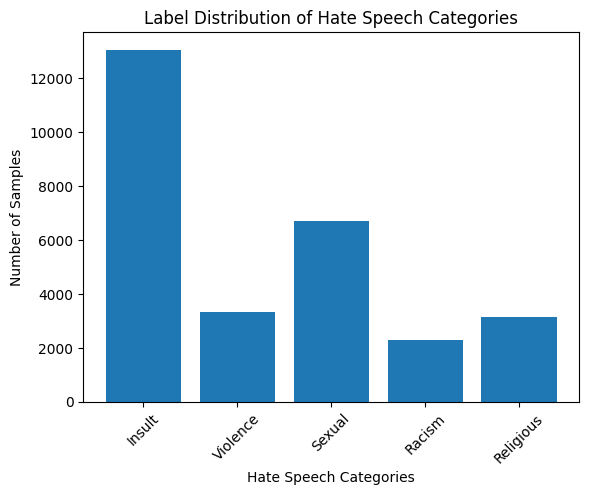

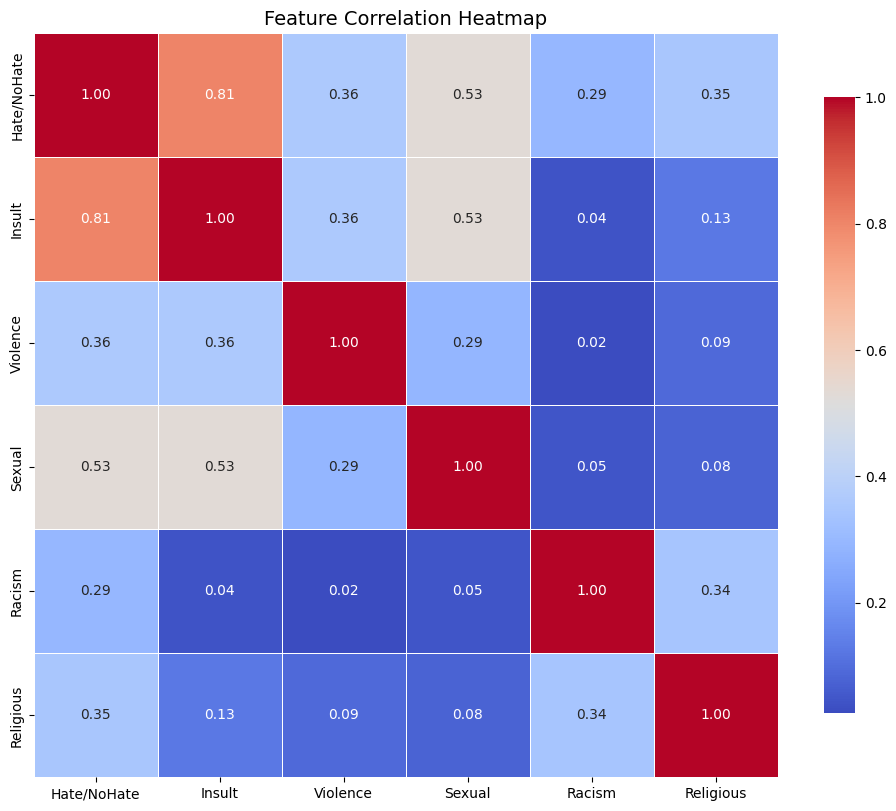

In [7]:
#7
# view label distribution and correlation map
sub_label_cols = ['Insult', 'Violence', 'Sexual', 'Racism', 'Religious']
label_counts = df[sub_label_cols].sum()

plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Hate Speech Categories")
plt.ylabel("Number of Samples")
plt.title("Label Distribution of Hate Speech Categories")
plt.xticks(rotation=45)
plt.show()

import seaborn as sns

numeric_cols = ['Hate/NoHate'] + sub_label_cols
corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


In [8]:
#8
#removal of unwanted characters and emojis
REMOVE_EMOJIS = True   # removes emojis as tokens
KEEP_PUNCT = False     # removes punctuations ! ? etc.

# Regex ranges:
# Devanagari: \u0900-\u097F (Nepali)
# Bengali:    \u0980-\u09FF
DEV_BEN_RANGE = r"\u0900-\u097F\u0980-\u09FF"

# A reasonable emoji/symbol removal pattern (covers many emoji blocks + pictographs)
EMOJI_PATTERN = re.compile(
    "[" 
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F700-\U0001F77F"  # alchemical
    "\U0001F780-\U0001F7FF"  # geometric
    "\U0001F800-\U0001F8FF"  # arrows
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U0001FA00-\U0001FA6F"  # chess etc
    "\U0001FA70-\U0001FAFF"  # symbols/objects
    "\u2600-\u26FF"          # misc symbols
    "\u2700-\u27BF"          # dingbats
    "]+", flags=re.UNICODE
)

In [9]:
# 9
# Text cleaning function (Nepali/Bengali safe)

def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)

    # 1) Unicode normalize (fixes weird forms, half forms, compatibility chars)
    s = unicodedata.normalize("NFKC", s)

    # 2) Normalize common social tokens
    s = re.sub(r"(https?://\S+|www\.\S+)", " URL ", s)
    s = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " EMAIL ", s)
    s = re.sub(r"@\w+", " USER ", s)

    # 3) Remove emojis if desired
    if REMOVE_EMOJIS:
        s = EMOJI_PATTERN.sub(" ", s)

    s = re.sub(r"[।॥|]+", " ", s)    # remove Nepali/Bengali sentence marks
    s = re.sub(r"\.{2,}", " ", s)    # remove ellipsis
    s = re.sub(r"(.)\1{2,}", r"\1", s) # spam removal


    # 4) Remove remaining junk symbols, but keep Nepali/Bengali + English letters/numbers
    if KEEP_PUNCT:
        # keep ! ? . , as potential aggression markers
        s = re.sub(fr"[^0-9A-Za-z{DEV_BEN_RANGE}\s\!\?\.,]", " ", s)
    else:
        s = re.sub(fr"[^0-9A-Za-z{DEV_BEN_RANGE}\s]", " ", s)

    # 5) Collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

df["clean_text"] = df[TEXT_COL].apply(clean_text)

display(df[[TEXT_COL, "clean_text"]].head(10))


,Comment,clean_text
0,भाक भोसडीके,भाक भोसडीके
1,पिक्चर स्पीक्स वाक मुजी,पिक्चर स्पीक्स वाक मुजी
2,हे मुजी....,हे मुजी
3,लस्तैइ ह्यान्डसम के मुजी 🤣❤️❤️❤️,लस्तैइ ह्यान्डसम के मुजी
4,आयो एमजी को कडा पर्सुस्तति♥️♥️♥️,आयो एमजी को कडा पर्सुस्तति
5,दाजु बे लाइक :- केरा हेरो भाको होस भेट्लास,दाजु बे लाइक केरा हेरो भाको होस भेट्लास
6,हे वास सेइङ घण्टा 😁😁,हे वास सेइङ घण्टा
7,बोका🤣😂🤣,बोका
8,आईएफ चुटिइया ठगुवा हद आ फेस 😆😂,आईएफ चुटिइया ठगुवा हद आ फेस
9,काण्ड नि हर्क्सु \nक्ति को बी र तिग्रा नि हर्क...,काण्ड नि हर्क्सु क्ति को बी र तिग्रा नि हर्क्स...


In [10]:
#10
# Drop duplicates (recommended for ML fairness + avoiding memorization)
before = len(df)
df = df.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before-after} duplicate rows based on clean_text.")


Removed 458 duplicate rows based on clean_text.


In [11]:
#11
# Remove empty / near-empty cleaned texts
df["word_count"] = df["clean_text"].str.split().apply(len)

before = len(df)
df = df[df["clean_text"].str.strip() != ""]
df = df[df["word_count"] >= 2]   # threshold: adjust (2 is safe)
df = df.reset_index(drop=True)
after = len(df)

print(f"Removed {before-after} rows (empty or too short after cleaning).")


Removed 779 rows (empty or too short after cleaning).


In [12]:
#12
# Quick before/after examples (random sample)
sample = df[[TEXT_COL, "clean_text"]].sample(10, random_state=42)
display(sample)


,Comment,clean_text
42436,"কথা গুলো যত শুনি ভাল্লাগছে, তখন আপার আবেগ কাজ ...",কথা গুলো যত শুনি ভাল্লাগছে তখন আপার আবেগ কাজ ক...
1644,अरु समाचार नपाएकै हो ??,अरु समाचार नपाएकै हो
29285,আমার মনে হয় অপু এখন যে কথা গুলো বলছে ওই কথা গু...,আমার মনে হয় অপু এখন যে কথা গুলো বলছে ওই কথা গ...
37369,তাহেরি মাকে চুদি,তাহেরি মাকে চুদি
10423,हार्दिक अभिवादन नवलपरासी पुर्वदेखि ।।,हार्दिक अभिवादन नवलपरासी पुर्वदेखि
36535,শালা পগল কোরানের কোন কথা নাই,শালা পগল কোরানের কোন কথা নাই
5055,यम दाए ले जे गाउनु हुन्क्सा साई गाउनु हुन्क्सा...,यम दाए ले जे गाउनु हुन्क्सा साई गाउनु हुन्क्सा...
18498,তার ব উ কে পাশি ছাই,তার ব উ কে পাশি ছাই
3053,इ डोन'टी नोव एनिथिङ बुट नेपाल लाई नेपोप को बाट...,इ डोन टी नोव एनिथिङ बुट नेपाल लाई नेपोप को बाट...
43453,"এই , বাইনচোদের জাত রোহিঙ্গারা চেহারা আর ব্যবহা...",এই বাইনচোদের জাত রোহিঙ্গারা চেহারা আর ব্যবহার ...


In [13]:
#13
# character length
df["char_len"] = df["clean_text"].str.len()

# unique words
df["unique_words"] = df["clean_text"].apply(lambda x: len(set(x.split())))

# punctuation count (basic)
df["punct_count"] = df[TEXT_COL].astype(str).str.count(r"[!?]")

df[["char_len","word_count","unique_words","punct_count"]].head()


,char_len,word_count,unique_words,punct_count
0,11,2,2,0
1,23,4,4,0
2,7,2,2,0
3,24,4,4,0
4,26,5,5,0


In [14]:
#14
df[["char_len","word_count","unique_words","punct_count"]].describe()


,char_len,word_count,unique_words,punct_count
count,45445.000000,45445.000000,45445.000000,45445.000000
mean,78.057234,14.265376,12.872131,0.231995
std,118.305058,20.756794,15.747342,1.040538
min,4.000000,2.000000,1.000000,0.000000
25%,27.000000,5.000000,5.000000,0.000000
50%,48.000000,9.000000,9.000000,0.000000
75%,87.000000,16.000000,15.000000,0.000000
max,3170.000000,534.000000,344.000000,38.000000


In [15]:
#15
from scipy.stats import skew

cols = ["char_len","word_count","unique_words","punct_count"]
for c in cols:
    print(c, "variance:", df[c].var(), "skewness:", skew(df[c]))


char_len variance: 13996.086747080279 skewness: 8.168340869964442
word_count variance: 430.84450243617266 skewness: 7.85789501768004
unique_words variance: 247.9787860685318 skewness: 6.0397955261550775
punct_count variance: 1.0827189437270603 skewness: 10.778715534318666


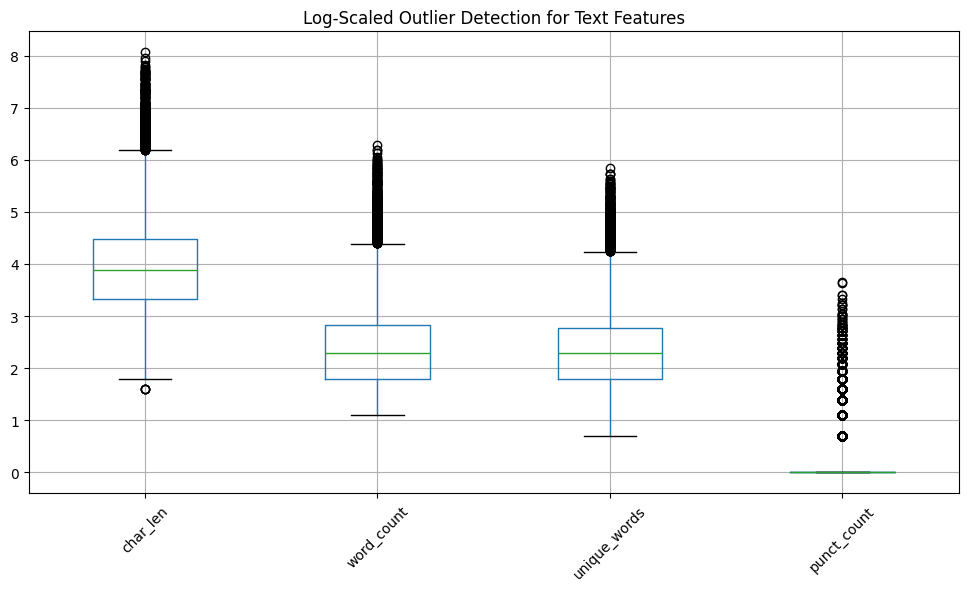

In [16]:
#16
import numpy as np
import matplotlib.pyplot as plt

cols = ["char_len","word_count","unique_words","punct_count"]

plt.figure(figsize=(12,6))
np.log1p(df[cols]).boxplot()
plt.title("Log-Scaled Outlier Detection for Text Features")
plt.xticks(rotation=45)
plt.show()


As we identified the outliers from the boxplot, we will do some steps to tackle this!


In [17]:
#17
#inspecting outliers to verify they are comments
df.sort_values("word_count", ascending=False)[["Comment","clean_text","word_count"]].head(20)


,Comment,clean_text,word_count
22188,আপনার শুরু থেকে আসি তাহসিনেশন। দেওয়ানবাগী হুজু...,আপনার শুরু থেকে আসি তাহসিনেশন দেওয়ানবাগী হুজু...,534
4186,हेल्लो है बताने भाइ कैसे हो आप आशा कर्ता हुन अ...,हेल्लो है बताने भाइ कैसे हो आप आशा कर्ता हुन अ...,491
26560,"পরম শ্রদ্ধেয় স্যার, একটা বিষয় বাদে আপনার সব ব...",পরম শ্রদ্ধেয় স্যার একটা বিষয় বাদে আপনার সব ব...,486
23132,মিয়ানমারের মতো মিলিটারি ডিক্টেটরের দেশের মানুষ...,মিয়ানমারের মতো মিলিটারি ডিক্টেটরের দেশের মানু...,461
27540,ড. মুহাম্মদ জাফর ইকবাল. তিনি ১৯৫২ সালের এই দি...,ড মুহাম্মদ জাফর ইকবাল তিনি ১৯৫২ সালের এই দিনে ...,429
27527,যে ছেলেটাকে নামাজের কথা বলায় জাফর স্যার পুলিশ...,যে ছেলেটাকে নামাজের কথা বলায় জাফর স্যার পুলিশ...,413
27284,*********** আপনি কি মুক্তিযুদ্ধের সপক্ষ শক্তি....,আপনি কি মুক্তিযুদ্ধের সপক্ষ শক্তি তাহলে সরকারক...,401
12639,সালাম পাপন সালা ভারত থেকে ভাল পলিটিকস সিখেছ আজ...,সালাম পাপন সালা ভারত থেকে ভাল পলিটিকস সিখেছ আজ...,399
25997,"আল কুরআন বলছে, যে বিষয়ে তোমার জ্ঞান নেই সে বি...",আল কুরআন বলছে যে বিষয়ে তোমার জ্ঞান নেই সে বিষ...,389
20870,তোর মত লেবাজধারী মানুষ শয়তানের দেওয়ানবাগী সম্প...,তোর মত লেবাজধারী মানুষ শয়তানের দেওয়ানবাগী সম...,387


In [18]:

#18
# Truncate very long comments (control extreme outliers)
#Since, TF-IDF does not benefit from extremely long tails, 
# we will cap the word count at 300

MAX_WORDS = 300  

df["clean_text"] = df["clean_text"].apply(
    lambda x: " ".join(x.split()[:MAX_WORDS])
)

# recompute word_count after truncation
df["word_count"] = df["clean_text"].str.split().apply(len)

print("Max words after truncation:", df["word_count"].max())


Max words after truncation: 300


In [19]:
# 19
# Train/test split (split BEFORE TF-IDF to avoid leakage)
X = df["clean_text"]
y = df[label_cols].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (36356,) Test: (9089,)


In [20]:
#20
# TF-IDF (word ngrams)
tfidf_word = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2
)

X_train_word = tfidf_word.fit_transform(X_train)
X_test_word  = tfidf_word.transform(X_test)

print("Word TF-IDF shapes:", X_train_word.shape, X_test_word.shape)
print("Word vocab size:", len(tfidf_word.vocabulary_))



Word TF-IDF shapes: (36356, 20000) (9089, 20000)
Word vocab size: 20000


In [21]:
#21
# applying Char TF-IDF ( for multilingual/noisy text)
from scipy.sparse import hstack

USE_CHAR_TFIDF = True

if USE_CHAR_TFIDF:
    tfidf_char = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3,5),
        min_df=2
    )
    X_train_char = tfidf_char.fit_transform(X_train)
    X_test_char  = tfidf_char.transform(X_test)

    X_train_feat = hstack([X_train_word, X_train_char])
    X_test_feat  = hstack([X_test_word,  X_test_char])
else:
    X_train_feat = X_train_word
    X_test_feat  = X_test_word

print("Final feature shapes:", X_train_feat.shape, X_test_feat.shape)


Final feature shapes: (36356, 161005) (9089, 161005)


In [22]:
#22
#df.to_csv("../Data/HateSpeechData_cleaned.csv", index=False)


In [23]:
#23 Train SVM (One-vs-Rest for multi-label)
svm_model = OneVsRestClassifier(
    LinearSVC(class_weight="balanced", random_state=42)
)

svm_model.fit(X_train_feat, y_train)
print("SVM training done!")


SVM training done!


In [24]:
#24
#10-fold cross-validation on TRAINING features
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

micro_f1 = make_scorer(f1_score, average="micro")
cv = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    svm_model,
    X_train_feat, y_train,
    cv=cv,
    scoring=micro_f1
)

print("10-fold CV micro-F1:", np.round(cv_scores, 4))
print("Mean:", cv_scores.mean().round(4), "Std:", cv_scores.std().round(4))


10-fold CV micro-F1: [0.8498 0.858  0.8559 0.8465 0.8366 0.8488 0.8542 0.8513 0.8608 0.8461]
Mean: 0.8508 Std: 0.0066


In [25]:
#25
# Predict on test set
y_pred = svm_model.predict(X_test_feat)
print("Predictions shape:", y_pred.shape)


Predictions shape: (9089, 6)


In [26]:
# Confusion matrices (per label) + classification report
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import numpy as np

mcm = multilabel_confusion_matrix(y_test, y_pred)

for i, label in enumerate(label_cols):
    tn, fp, fn, tp = mcm[i].ravel()

    acc = (tp + tn) / (tp + tn + fp + fn)

    print(f"\nLabel: {label}")
    print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}  Accuracy={acc:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_cols, zero_division=0))



Label: Hate/NoHate
TN=5278  FP=371  FN=480  TP=2960  Accuracy=0.9064

Label: Insult
TN=6150  FP=384  FN=393  TP=2162  Accuracy=0.9145

Label: Violence
TN=8212  FP=223  FN=171  TP=483  Accuracy=0.9567

Label: Sexual
TN=7635  FP=128  FN=184  TP=1142  Accuracy=0.9657

Label: Racism
TN=8647  FP=12  FN=42  TP=388  Accuracy=0.9941

Label: Religious
TN=8415  FP=82  FN=95  TP=497  Accuracy=0.9805

=== Classification Report ===
              precision    recall  f1-score   support

 Hate/NoHate       0.89      0.86      0.87      3440
      Insult       0.85      0.85      0.85      2555
    Violence       0.68      0.74      0.71       654
      Sexual       0.90      0.86      0.88      1326
      Racism       0.97      0.90      0.93       430
   Religious       0.86      0.84      0.85       592

   micro avg       0.86      0.85      0.86      8997
   macro avg       0.86      0.84      0.85      8997
weighted avg       0.87      0.85      0.86      8997
 samples avg       0.33      0.31 

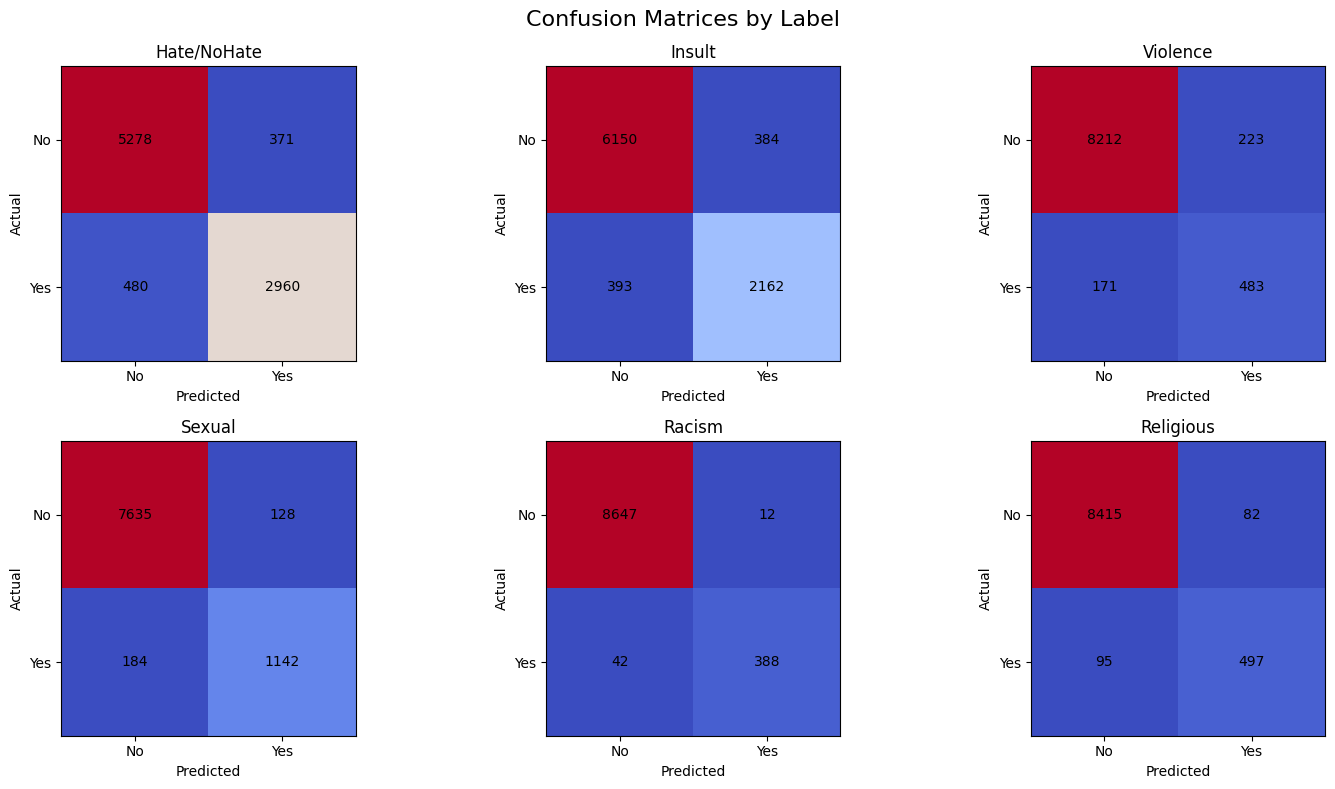

Done plotting confusion matrices.


In [27]:
# Plot multilabel confusion matrices in ONE figure (side by side)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

n_labels = len(label_cols)
cols = 3                          # how many per row (change if you want)
rows = int(np.ceil(n_labels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, label in enumerate(label_cols):
    tn, fp, fn, tp = mcm[i].ravel()
    cm = np.array([[tn, fp],
                   [fn, tp]])

    ax = axes[i]
    im = ax.imshow(cm, cmap="coolwarm")   # light blue ↔ light red

    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No", "Yes"])
    ax.set_yticklabels(["No", "Yes"])

    # write numbers
    for r in range(2):
        for c in range(2):
            ax.text(c, r, cm[r, c], ha="center", va="center", color="black")

# hide unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Confusion Matrices by Label", fontsize=16)
plt.tight_layout()
plt.show()

print("Done plotting confusion matrices.")


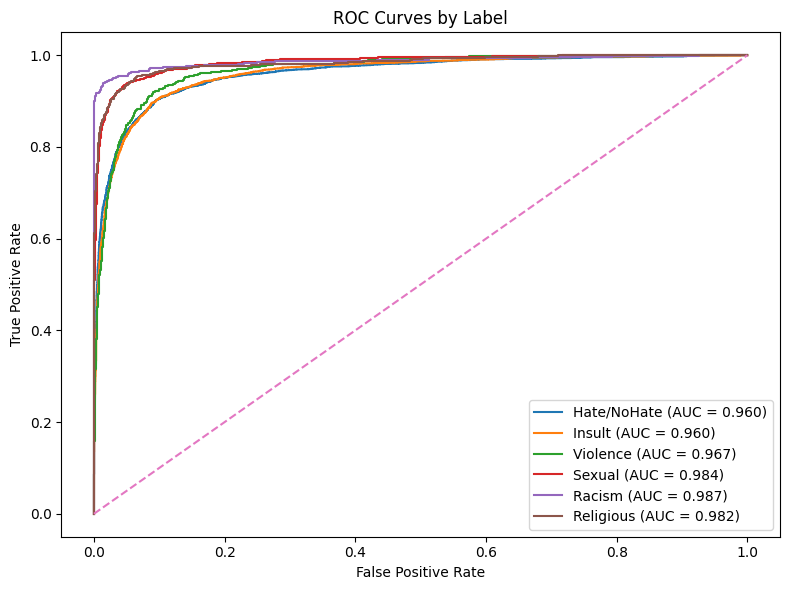

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# decision scores from SVM
y_scores = svm_model.decision_function(X_test_feat)

plt.figure(figsize=(8, 6))

for i, lab in enumerate(label_cols):
    y_true = y_test[lab].values
    
    # Skip if only one class present
    if len(np.unique(y_true)) < 2:
        print(f"Skipping {lab} (only one class in y_test)")
        continue

    fpr, tpr, _ = roc_curve(y_true, y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{lab} (AUC = {roc_auc:.3f})")

# diagonal random baseline
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Label")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# 26
# Stress testing the algorithm
# Predict on a new Nepali/Bengali comment (interactive)

def predict_comment(text: str):
    # 1) clean the raw input using the SAME cleaning function
    cleaned = clean_text(text)

    # 2) vectorize using the already-fitted TF-IDF objects
    x_word = tfidf_word.transform([cleaned])

    if "USE_CHAR_TFIDF" in globals() and USE_CHAR_TFIDF:
        x_char = tfidf_char.transform([cleaned])
        x_feat = hstack([x_word, x_char])
    else:
        x_feat = x_word

    # 3) decision scores (more informative than only 0/1)
    scores = svm_model.decision_function(x_feat)  # shape (1, num_labels)
    scores = scores[0]

    # default threshold is 0.0; you can tune later
    thresholds = {lab: 0.0 for lab in label_cols}

    pred = np.array([1 if scores[i] >= thresholds[label_cols[i]] else 0
                 for i in range(len(label_cols))])

    results = dict(zip(label_cols, pred.astype(int)))

    # --- Hierarchical consistency ---
    sub_cols = [c for c in label_cols if c != "Hate/NoHate"]

    # If any subtype is predicted 1, Hate must be 1
    if any(results[c] == 1 for c in sub_cols):
        results["Hate/NoHate"] = 1

    # If Hate is 0, wipe out subcategories
    if results["Hate/NoHate"] == 0:
        for c in sub_cols:
            results[c] = 0

    print("Raw:", text)
    print("Cleaned:", cleaned)

    print("\nDecision scores (higher = more confident):")
    for i, lab in enumerate(label_cols):
        print(f"  {lab}: {scores[i]:.3f}")

    print("\nPredictions:")
    for k, v in results.items():
        print(f"  {k}: {v}")


    # helper summary
    if results.get("Hate/NoHate", 0) == 1:
        cats = [c for c in label_cols if c != "Hate/NoHate" and results[c] == 1]
        print("\nSummary: HATE ")
        print("Categories:", ", ".join(cats) if cats else "(none predicted)")
    else:
        print("\nSummary: NOT HATE ")

    return results



In [30]:
# Example usage:
print("Your work is very good.")
predict_comment("तपाईंको काम एकदम राम्रो छ।")


print("\n")
print("Thief, started barking again")
predict_comment("चोर फेरी भुक्नु थालीस")


print("\n")
print("Shame! Down with the Speaker")
predict_comment(" थुक्क, त्यो सभमुख महोदय मुर्दाबाद।")

print("\n")
print("I really liked your video.")
predict_comment("তোমার ভিডিওটা খুব ভালো লেগেছে।")

print("\n")
print("I will kill him.")
predict_comment("ওকে মেরে ফেলবো।")


print("\n")
print("You are an idiot.")
predict_comment("তুই একটা বোকা।")



Your work is very good.
Raw: तपाईंको काम एकदम राम्रो छ।
Cleaned: तपाईंको काम एकदम राम्रो छ

Decision scores (higher = more confident):
  Hate/NoHate: -1.049
  Insult: -1.193
  Violence: -1.958
  Sexual: -1.189
  Racism: -1.294
  Religious: -1.712

Predictions:
  Hate/NoHate: 0
  Insult: 0
  Violence: 0
  Sexual: 0
  Racism: 0
  Religious: 0

Summary: NOT HATE 


Thief, started barking again
Raw: चोर फेरी भुक्नु थालीस
Cleaned: चोर फेरी भुक्नु थालीस

Decision scores (higher = more confident):
  Hate/NoHate: 1.246
  Insult: 1.166
  Violence: -1.579
  Sexual: -1.225
  Racism: -1.363
  Religious: -1.642

Predictions:
  Hate/NoHate: 1
  Insult: 1
  Violence: 0
  Sexual: 0
  Racism: 0
  Religious: 0

Summary: HATE 
Categories: Insult


Shame! Down with the Speaker
Raw:  थुक्क, त्यो सभमुख महोदय मुर्दाबाद।
Cleaned: थुक्क त्यो सभमुख महोदय मुर्दाबाद

Decision scores (higher = more confident):
  Hate/NoHate: 0.773
  Insult: 0.377
  Violence: -0.855
  Sexual: -1.038
  Racism: -0.722
  Religious: -1

{'Hate/NoHate': 1,
 'Insult': np.int64(1),
 'Violence': np.int64(0),
 'Sexual': np.int64(0),
 'Racism': np.int64(0),
 'Religious': np.int64(0)}